In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
style_path = 'Tensorflow dump\styleimage.jpg'
content_path = 'Tensorflow dump\content.jpg'
def import_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img,size=(224,224))
    img = tf.expand_dims(img,axis=0)
    img = img/255.0
    # img = tf.keras.applications.vgg19.preprocess_input(img)
    return img
style_img = import_img(style_path)
content_img = import_img(content_path)

In [3]:
# gen_img = tf.random.uniform(shape=(1,224,224,3),minval=0,maxval=1)
gen_img = import_img(content_path)
gen_img = tf.Variable(gen_img,trainable=True)

(-0.5, 223.5, 223.5, -0.5)

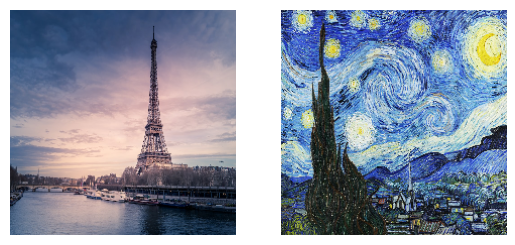

In [4]:
# print(tf.reduce_max(gen_img),tf.reduce_min(gen_img))
# plt.figure(1)
# plt.imshow(tf.squeeze(gen_img))
# plt.figure(2)
# plt.imshow(tf.squeeze(style_img)) 

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(tf.squeeze(gen_img))
ax1.axis(False)
ax2.imshow(tf.squeeze(style_img))
ax2.axis(False)

In [5]:
vgg = tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False)
vgg.trainable = False
class model(tf.keras.Model):
    def __init__(self) -> None:
        super(model,self).__init__()
        self.chosen = [1,4,7,12,17,13]
        self.trainer = vgg
    def call(self,x):
        features = []
        for layer_no,layer in enumerate(self.trainer.layers):
            x = layer(x)
            if layer_no in self.chosen:
                features.append(x)
        return features
trainer = model()

In [6]:
learning_rate = 0.007
epochs = 1000
alpha = 2.5e-1
beta = 1e-2
optim = tf.keras.optimizers.Adam(learning_rate)
for epoch in range(epochs+1):
    styleloss = contentloss = 0
    with tf.GradientTape() as tape:
        tape.watch(gen_img)
        gen_features = trainer(gen_img)
        style_features = trainer(style_img)
        content_features = trainer(content_img)
        contentloss = tf.reduce_sum((gen_features[-1] - content_features[-1])**2)
        style_weights = [0.4,0.06,0.01,0.00001,0.00]
        i = 0
        for gen_feature,style_feature,content_feature in tuple(zip(gen_features,style_features,content_features))[:-1]:
            batch_size,height,width,channels = gen_feature.shape
            # Compute the content loss...
            # contentloss += tf.reduce_sum((gen_feature-content_feature)**2)
            # Compute the gram matrices...
            S = tf.matmul(tf.reshape(style_feature,shape=(channels,height*width)),tf.reshape(style_feature,shape=(channels,height*width)),transpose_b=True)
            G = tf.matmul(tf.reshape(gen_feature,shape=(channels,height*width)),tf.reshape(gen_feature,shape=(channels,height*width)),transpose_b=True)
            # S = tf.matmul(style_feature,style_feature,transpose_b=True)
            # G = tf.matmul(gen_feature,gen_feature,transpose_b=True)
            # Compute the style loss...
            styleloss += (style_weights[i]*tf.reduce_sum((G-S)**2))
            # print(styleloss)
            i += 1
        loss = (alpha*contentloss) + (beta*styleloss)
    if epoch%1000==0:
        print(f"Processing epoch: {int(epoch/1000) + 1}")
    grads = tape.gradient(loss,[gen_img])
    optim.apply_gradients(zip(grads,[gen_img]))

Processing epoch: 1
Processing epoch: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


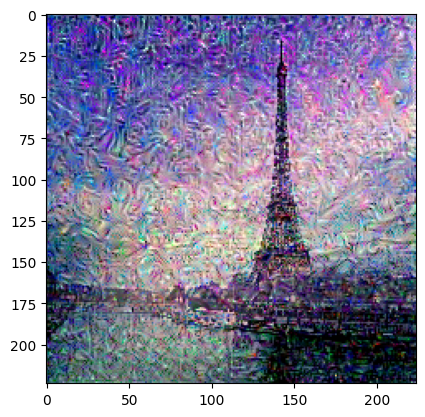

In [7]:
# print(tf.reduce_max(gen_img),tf.reduce_min(gen_img))
plt.imshow(tf.squeeze(gen_img))